Question: Can we use reach difference between two fighters to predict fight outcomes?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../../data/ufc-master.csv')

Fixing mistakes in the data before using it

In [3]:
filter1 = (data['reach_dif'] == -187.96) & (data['B_fighter'] == 'Parker Porter')
filter2 = (data['reach_dif'] == -187.96) & (data['B_fighter'] == 'Irwin Rivera')
filter3 = data['reach_dif'] == -160.02
data[filter1] = data[filter1].replace({-187.96: -2.54})
data[filter2] = data[filter2].replace({-187.96: -17.78 })
data[filter3] = data[filter3].replace({-160.02: 5.08})

It is important to note that even though the reach values are in centimeters they were originally measured in inches and we have to take that into consideration later on.

First let's check how often fighter with a longer reach wins.

In [4]:
#First excluding fights where both fighters have the same reach
not_equal = data['reach_dif'] != 0
data_wo_equal = data[not_equal][['reach_dif', 'Winner']]
wins = 0
for i in range(len(data_wo_equal)):
    if (data_wo_equal['reach_dif'].iloc[i] > 0) & (data_wo_equal['Winner'].iloc[i] == 'Blue'):
        wins += 1
    elif (data_wo_equal['reach_dif'].iloc[i] < 0) & (data_wo_equal['Winner'].iloc[i] == 'Red'):
        wins += 1
print("Fighter with a longer reach wins " + str(round((wins / len(data_wo_equal)) * 100, 2)) + "% of the time.")
print("Sample size (number of fights where the reach difference is greater than 0): " + str(len(data_wo_equal)))

Fighter with a longer reach wins 52.63% of the time.
Sample size (number of fights where the reach difference is greater than 0): 3914


Eventhough the 52.7% is not a lot it still shows that most of the time fighter with a reach advantage wins. This raises the question: when does the reach advantage become significant?

First we will check scenarios where one fighter has a reach advantage of at least x cm and how it affects the fight outcome. It is important to note that in this case one fight can appear simultaneously in multiple scenarios. For example if one fighter has a reach advantage of 10cm in a certain fight, then this fight affects the outcome in scenarios where one fighter has a reach advantage of at least 2.5cm, 5cm, 7.5cm and 10cm. Because of that we are later also going to split reach advantages into categories like 0-2.54, 2.55-5.08 etc and see if this makes a difference.

In [5]:
results = []
differences = []
sample_sizes = []
inch = 2.54
for i in range(1, 11, 1):
    if i == 1:
        #We exclude cases where both fighters have exactly the same reach
        reachFilter = (abs(data['reach_dif']) <= inch * i) & (data['reach_dif'] != 0)
    else:
        reachFilter = abs(data['reach_dif']) > inch * i
    data_filtered = data[reachFilter][['reach_dif', 'Winner']]
    reach_adv = 0 #Fighter with the reach advantage won
    filtered_data_size = len(data_filtered)
    if (filtered_data_size < 0.01 * len(data)):
        #If the sample size is less than 1% of the fights we are not looking further
        break
    differences.append(i * inch)
    sample_sizes.append(filtered_data_size)
    for j in range(len(data_filtered)):
        #Reach difference in the dataset is calculated as blue reach - red reach
        if (data_filtered['reach_dif'].iloc[j] > 0) & (data_filtered['Winner'].iloc[j] == 'Blue'):
            reach_adv += 1
        elif (data_filtered['reach_dif'].iloc[j] < 0) & (data_filtered['Winner'].iloc[j] == 'Red'):
            reach_adv += 1
    results.append(reach_adv / filtered_data_size)

In [6]:
for i in range (len(results)):
    if i == 0:
        print("When the fighter with a longer reach had a reach advantage of less than or equal to " + str(differences[i]) +
              "cm he/she won " +  str(round(results[i] * 100, 2)) + "% of the time. Sample size was " + 
              str(sample_sizes[i]) + ".")
    else:
        print("When the fighter with a longer reach had a reach advantage that was greater than " + str(differences[i]) +
              "cm he/she won " + str(round(results[i] * 100, 2)) + "% of the time. Sample size was " +
              str(sample_sizes[i]) + ".")

When the fighter with a longer reach had a reach advantage of less than or equal to 2.54cm he/she won 49.87% of the time. Sample size was 1121.
When the fighter with a longer reach had a reach advantage that was greater than 5.08cm he/she won 55.31% of the time. Sample size was 1949.
When the fighter with a longer reach had a reach advantage that was greater than 7.62cm he/she won 55.63% of the time. Sample size was 1235.
When the fighter with a longer reach had a reach advantage that was greater than 10.16cm he/she won 56.79% of the time. Sample size was 780.
When the fighter with a longer reach had a reach advantage that was greater than 12.7cm he/she won 57.92% of the time. Sample size was 461.
When the fighter with a longer reach had a reach advantage that was greater than 15.24cm he/she won 60.26% of the time. Sample size was 229.
When the fighter with a longer reach had a reach advantage that was greater than 17.78cm he/she won 67.89% of the time. Sample size was 109.
When the fi

These results show us that there certainly seems to be strong correlation between the fighters reach advantage and win probability.

Now we look the fight outcomes when we divide reach differences into excluding categories so that one fight can only appear once. We will use a step of 2.54cm because as we pointed out before even though the reach values are in centimeters they were measured using inches. As before we exclude fights where both fighters had the same reach.

In [7]:
filter2 = data['reach_dif'] != 0
data2 = data[filter2][['reach_dif', 'Winner']]
thresholds = []
results2 = []
sample_sizes_2 = []
#From the previous results we can see that the highest category should be 20.32+
for i in range(1, 9, 1):
    thresholds.append(2.54 * i)
for i in range(len(thresholds) + 1):
    if i == 0:
        reachFilt = abs(data2['reach_dif']) <= thresholds[i]
    elif i == len(thresholds):
        reachFilt = abs(data2['reach_dif']) > thresholds[i - 1]
    else:
        reachFilt = (abs(data2['reach_dif']) > thresholds[i - 1]) & (abs(data2['reach_dif']) <= thresholds[i])
    data_filtered_2 = data2[reachFilt]
    adv_wins_2 = 0 #Fighter with a reach advantage won
    sample_sizes_2.append(len(data_filtered_2))
    for j in range(len(data_filtered_2)):
        #Because we have already filtered the data we only have to check whether the difference is positive or negative
        if (data_filtered_2['reach_dif'].iloc[j] > 0) & (data_filtered_2['Winner'].iloc[j] == 'Blue'):
            adv_wins_2 += 1
        elif (data_filtered_2['reach_dif'].iloc[j] < 0) & (data_filtered_2['Winner'].iloc[j] == 'Red'):
            adv_wins_2 += 1
    results2.append(adv_wins_2 / len(data_filtered_2))

In [8]:
for i in range(len(results2)):
    if i == 0:
        print("When the reach difference was between (0, 2.54] centimeters the fighter with the longer reach won " +
              str(round(results2[i] * 100, 2)) + "% of the time.")
        print("Sample size was " + str(sample_sizes_2[i]) + ".\n")
    elif i == len(results2) - 1:
        print("When the reach difference was between more than 20.32 centimers the fighter with the longer reach won " +
              str(round(results2[i] * 100, 2)) + "% of the time.")
        print("Sample size was " + str(sample_sizes_2[i]) + ".\n")
    else:
        print("When the reach difference was between (" + str(thresholds[i - 1]) +", " + str(thresholds[i]) + "] centimeters the fighter with the longer reach won " +
              str(round(results2[i] * 100, 2)) + "% of the time.")
        print("Sample size was " + str(sample_sizes_2[i]) + ".\n")

When the reach difference was between (0, 2.54] centimeters the fighter with the longer reach won 49.87% of the time.
Sample size was 1121.

When the reach difference was between (2.54, 5.08] centimeters the fighter with the longer reach won 50.12% of the time.
Sample size was 844.

When the reach difference was between (5.08, 7.62] centimeters the fighter with the longer reach won 54.76% of the time.
Sample size was 714.

When the reach difference was between (7.62, 10.16] centimeters the fighter with the longer reach won 53.63% of the time.
Sample size was 455.

When the reach difference was between (10.16, 12.7] centimeters the fighter with the longer reach won 55.17% of the time.
Sample size was 319.

When the reach difference was between (12.7, 15.24] centimeters the fighter with the longer reach won 55.6% of the time.
Sample size was 232.

When the reach difference was between (15.24, 17.78] centimeters the fighter with the longer reach won 53.33% of the time.
Sample size was 120

Similarly to the previous test these results show us that reach advantage certainly plays a role in the outcome of the fight. This is very noticeable when the reach advantage of one fighter is greater than 17.78 cm.

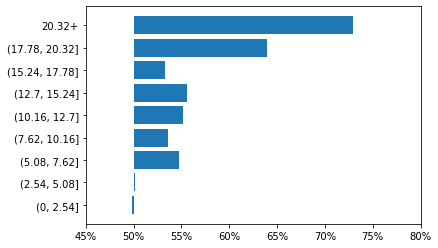

In [9]:
#Simple chart that shows win rates for different categories (center is 50% win rate)
plt.figure()
categories = ['(0, 2.54]', '(2.54, 5.08]', '(5.08, 7.62]',  '(7.62, 10.16]', '(10.16, 12.7]', '(12.7, 15.24]', '(15.24, 17.78]',
          '(17.78, 20.32]', '20.32+']
results_chart = []
for i in range(len(results2)):
    results_chart.append(results2[i] - 0.5)
plt.barh(categories, results_chart)
ticks = [-0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
labels = ["45%", "50%", "55%", "60%", "65%", "70%", "75%", "80%"]
plt.xticks(ticks, labels)
plt.show()

Regular bar chart

<function matplotlib.pyplot.show(*args, **kw)>

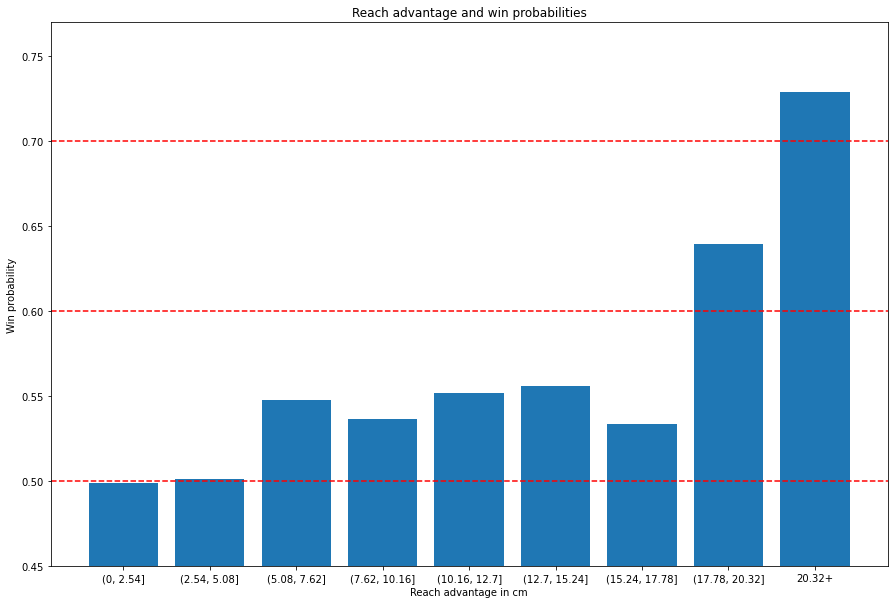

In [37]:
plt.figure(figsize=(15, 10))
plt.title("Reach advantage and win probabilities")
plt.ylabel("Win probability")
plt.xlabel("Reach advantage in cm")
plt.bar(categories, results2)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axhline(y=0.6, color='r', linestyle='--')
plt.axhline(y=0.7, color='r', linestyle='--')
plt.ylim((0.45, 0.77))
plt.show